In [66]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim import Optimizer

from sgd import SGD
from dog import DoG, LDoG
from dadapt import DAdaptSGD, DAdaptDual
from averager import PolynomialDecayAverager

from abc import abstractmethod
from tqdm.notebook import tqdm
import time

In [2]:
def add_gaussian_noise(tensor: torch.Tensor, mean: float = 0, std: float = 1):
    return tensor + (torch.randn_like(tensor) + mean) * std

In [72]:
class TorchModel:
    def __init__(self, n_features: int, init_point: torch.Tensor = None):
        self.N = n_features
        self.optimum = float('inf')
        self.x = None
        self.optimizer = None
        self.scheduler = None
        self.optimal_x = None

    def set_optimizer(self, optimizer: Optimizer):
        self.optimizer = optimizer

    def set_scheduler(self, scheduler: PolynomialDecayAverager):
        self.scheduler = scheduler

    @abstractmethod
    def loss(self, P: torch.Tensor, q: torch.Tensor):
        raise NotImplementedError("must override loss")

    def optimize(self, P: torch.Tensor, q: torch.Tensor, optimal_point,
                 max_iter: int = 10000, log_per: int = 1000, is_noisy: bool = True, noise_std: float = 0.1):
        print(self.x)
        self.P = P
        self.q = q
        point_distance_list = []
        value_distance_list = []
        optimal_value = self.compute_value(optimal_point)

        for _ in tqdm(range(max_iter)):
            self.optimizer.zero_grad()
            loss = self.loss(P, q)
            loss.backward()
            if is_noisy:
                self.x.grad += add_gaussian_noise(self.x.grad, std=noise_std)
            self.optimizer.step()
            if self.scheduler is not None:
                self.scheduler.step()

            current_value = self.compute_value(self.x.detach().numpy())
            point_distance = np.linalg.norm(self.x.detach().numpy() - optimal_point)
            value_distance = current_value - optimal_value
            point_distance_list.append(point_distance)
            value_distance_list.append(value_distance)
            if _ % log_per == 0:
                tqdm.write(f"Iter: {_}, \tPoint Distance (d_i) from Optimal: {'%.6f' % point_distance}, \tValue Distance from Optimal: \t{'%.6f' % value_distance}", end='\r')
                time.sleep(1)

            if current_value < self.optimum:
                self.optimal_x = self.x
                self.optimum = current_value

        return point_distance_list, value_distance_list

    @abstractmethod
    def optimal_value(self):
        raise NotImplementedError("must override optimal_value")

    @abstractmethod
    def compute_value(self):
        raise NotImplementedError("must override compute_value")

    def params(self):
        return [self.x]

In [73]:
class TorchQuadModel(TorchModel):
    def __init__(self, n_features: int, init_point: torch.Tensor = None, **kwargs):
        super().__init__(n_features, init_point, **kwargs)
        if init_point is None:
            self.x = torch.randn(self.N, requires_grad=True)
        else:
            self.x = init_point.clone().detach()
            self.x.requires_grad = True

    def loss(self, P: torch.Tensor, q: torch.Tensor):
        x1 = torch.matmul(self.x, P) # x1 = x^T P
        z = torch.matmul(x1, self.x) # z = x1 x = x^T P x

        # x^T P x - q^T x
        return z - torch.matmul(q, self.x)

    def optimal_value(self):
        return self.optimum

    def compute_value(self, point: np.ndarray):
        P = self.P.detach().numpy()
        q = self.q.detach().numpy()
        return point.T @ P @ point - q @ point

In [69]:
N = 5 # Matrix Size
A = np.random.rand(N, N)
P = torch.from_numpy((A.T @ A).astype('float32'))
q = torch.from_numpy(np.random.rand(N).astype(dtype='float32'))

In [70]:
from solver import QuadraticSolver

qs = QuadraticSolver(N, P.detach().numpy(), q.detach().numpy())
qs.optimal_point()
qs.optimal_value()

-0.9880231213224634

In [74]:
def quadratic_model_runner(optimizer: Optimizer, model: TorchModel,
                           P: torch.Tensor,
                           q: torch.Tensor,
                           optimal_point: float,
                           max_iter: int = 10000,
                           log_per_iteration: int = 1000,
                           is_noisy: bool = True,
                           noise_std: float = 0.01):
    model.set_optimizer(optimizer)
    point_distance_list, value_distance_list = model.optimize(P,
                                                              q,
                                                              optimal_point,
                                                              max_iter,
                                                              log_per_iteration,
                                                              is_noisy, noise_std)
    log_distance_list = np.log(np.abs(np.array(value_distance_list)))
    print()
    print()
    time.sleep(1)

    return point_distance_list, value_distance_list, log_distance_list

Noise STD = 0.01
SGD Method
tensor([ 0.3654, -0.3742, -0.6845, -0.2166, -0.2854], requires_grad=True)


  0%|          | 0/10001 [00:00<?, ?it/s]

Iter: 10000, 	Point Distance (d_i) from Optimal: 2.867745, 	Value Distance from Optimal: 	0.132899

DoG Method
tensor([ 0.3654, -0.3742, -0.6845, -0.2166, -0.2854], requires_grad=True)


  0%|          | 0/10001 [00:00<?, ?it/s]

Iter: 10000, 	Point Distance (d_i) from Optimal: 0.005051, 	Value Distance from Optimal: 	0.000002

DAdaptSGD Method
tensor([ 0.3654, -0.3742, -0.6845, -0.2166, -0.2854], requires_grad=True)


  0%|          | 0/10001 [00:00<?, ?it/s]

Iter: 10000, 	Point Distance (d_i) from Optimal: 3.130349, 	Value Distance from Optimal: 	0.158673

DAdaptDual Method
tensor([ 0.3654, -0.3742, -0.6845, -0.2166, -0.2854], requires_grad=True)


  0%|          | 0/10001 [00:00<?, ?it/s]

Iter: 10000, 	Point Distance (d_i) from Optimal: 0.057386, 	Value Distance from Optimal: 	0.000053

Noise STD = 1
SGD Method
tensor([ 0.3654, -0.3742, -0.6845, -0.2166, -0.2854], requires_grad=True)


  0%|          | 0/10001 [00:00<?, ?it/s]

Iter: 10000, 	Point Distance (d_i) from Optimal: 2.885995, 	Value Distance from Optimal: 	0.134699

DoG Method
tensor([ 0.3654, -0.3742, -0.6845, -0.2166, -0.2854], requires_grad=True)


  0%|          | 0/10001 [00:00<?, ?it/s]

Iter: 10000, 	Point Distance (d_i) from Optimal: 0.170014, 	Value Distance from Optimal: 	0.007607

DAdaptSGD Method
tensor([ 0.3654, -0.3742, -0.6845, -0.2166, -0.2854], requires_grad=True)


  0%|          | 0/10001 [00:00<?, ?it/s]

Iter: 10000, 	Point Distance (d_i) from Optimal: 3.536308, 	Value Distance from Optimal: 	0.202463

DAdaptDual Method
tensor([ 0.3654, -0.3742, -0.6845, -0.2166, -0.2854], requires_grad=True)


  0%|          | 0/10001 [00:00<?, ?it/s]

Iter: 10000, 	Point Distance (d_i) from Optimal: 0.324730, 	Value Distance from Optimal: 	0.007020

Noise STD = 100
SGD Method
tensor([ 0.3654, -0.3742, -0.6845, -0.2166, -0.2854], requires_grad=True)


  0%|          | 0/10001 [00:00<?, ?it/s]

Iter: 10000, 	Point Distance (d_i) from Optimal: 3.856291, 	Value Distance from Optimal: 	1.786902

DoG Method
tensor([ 0.3654, -0.3742, -0.6845, -0.2166, -0.2854], requires_grad=True)


  0%|          | 0/10001 [00:00<?, ?it/s]

Iter: 10000, 	Point Distance (d_i) from Optimal: 5.877425, 	Value Distance from Optimal: 	1.052004

DAdaptSGD Method
tensor([ 0.3654, -0.3742, -0.6845, -0.2166, -0.2854], requires_grad=True)


  0%|          | 0/10001 [00:00<?, ?it/s]

Iter: 10000, 	Point Distance (d_i) from Optimal: 5.843223, 	Value Distance from Optimal: 	3.044074

DAdaptDual Method
tensor([ 0.3654, -0.3742, -0.6845, -0.2166, -0.2854], requires_grad=True)


  0%|          | 0/10001 [00:00<?, ?it/s]

Iter: 10000, 	Point Distance (d_i) from Optimal: 5.844543, 	Value Distance from Optimal: 	3.098212



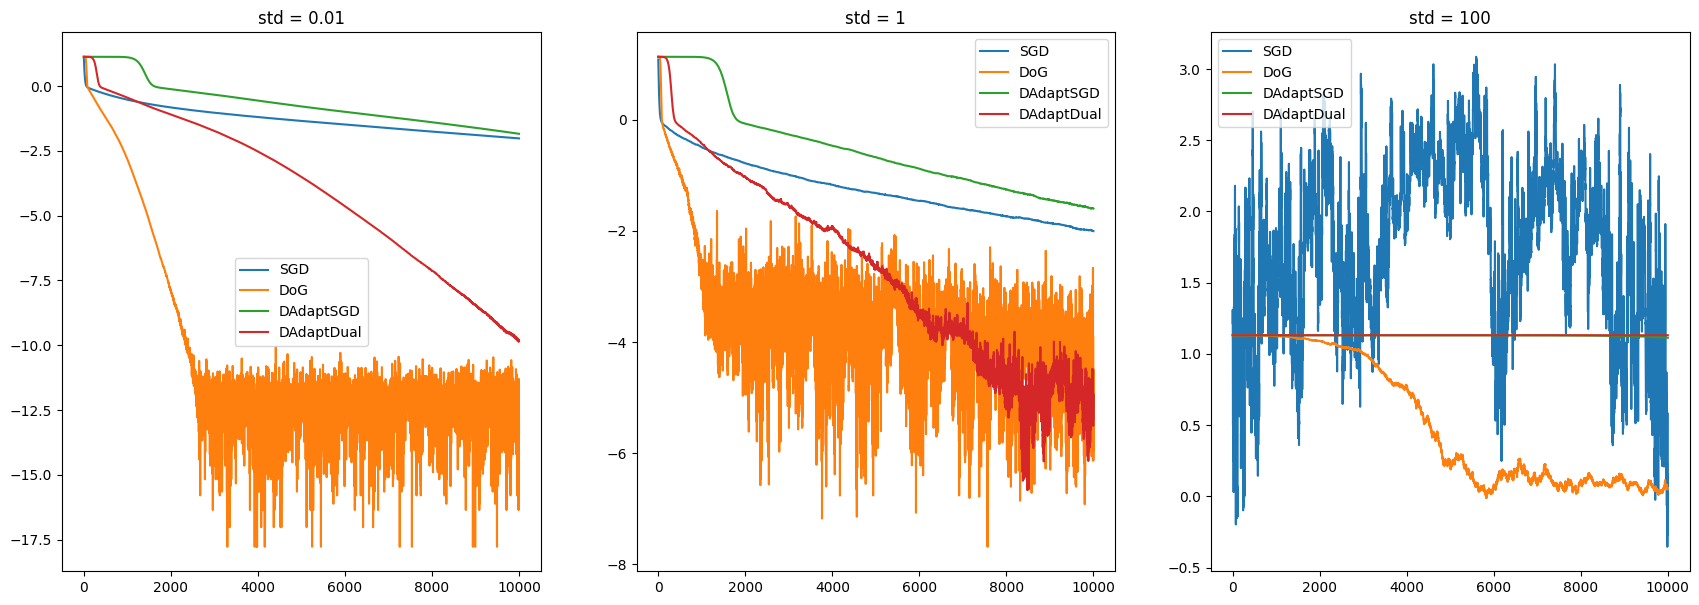

In [81]:
iterations = 10001
init = torch.randn(N, requires_grad=True)


noise_levels = [0.01, 1, 100]
fig, ax = plt.subplots(1, len(noise_levels), figsize=(21, 7))
for j, nl in enumerate(noise_levels):
    print(f"Noise STD = {nl}")

    # SGD Method
    sgd_model = TorchQuadModel(N, init)
    sgd_optimizer = SGD(sgd_model.params(), lr = 0.001)

    # DoG Method
    dog_model = TorchQuadModel(N, init)
    dog_optimizer = DoG(dog_model.params())

    # D-Adaptation (SGD) Method
    dadapt_sgd_model = TorchQuadModel(N, init)
    dadapt_sgd_optimizer = DAdaptSGD(dadapt_sgd_model.params(), lr = 0.01)

    # D-Adaptation (Dual Averaging) Method
    dadapt_dual_model = TorchQuadModel(N, init)
    dadapt_dual_optimizer = DAdaptDual(dadapt_dual_model.params())


    optimizers = [[sgd_optimizer, sgd_model],
                [dog_optimizer, dog_model],
                [dadapt_sgd_optimizer, dadapt_sgd_model],
                [dadapt_dual_optimizer, dadapt_dual_model]]
    for i, (optimizer, model) in enumerate(optimizers):
        optimizer_name = optimizer.__class__.__name__
        print(f"{optimizer_name} Method")
        point_dist_list, value_dist_list, log_dist_list = quadratic_model_runner(optimizer,
                                                                                 model,
                                                                                 P,
                                                                                 q,
                                                                                 qs.optimal_point(), max_iter=iterations, log_per_iteration=1000,
                                                                                 noise_std=nl)
        ax[j].plot(log_dist_list, label=optimizer_name)
    ax[j].legend()
    ax[j].set_title(f"std = {nl}")

# plt.legend()
# plt.show()

In [77]:
print(f"Actual optimal point: \t{qs.optimal_value()}")
print(f"DoG optimal point: \t{dog_model.optimal_value()}")
print(f"SGD optimal point: \t{sgd_model.optimal_value()}")
print(f"D-Adapt (SGD) optimal point: \t{dadapt_sgd_model.optimal_value()}")
print(f"D-Adapt (DA) optimal point: \t{dadapt_dual_model.optimal_value()}")

Actual optimal point: 	-0.9880231213224634
DoG optimal point: 	3.359139919281006
SGD optimal point: 	-0.828825831413269
D-Adapt (SGD) optimal point: 	3.615746021270752
D-Adapt (DA) optimal point: 	3.6173324584960938


SGD Method
tensor([ 0.3654, -0.3742, -0.6845, -0.2166, -0.2854], requires_grad=True)


  0%|          | 0/100001 [00:00<?, ?it/s]

Iter: 100000, 	Point Distance (d_i) from Optimal: 2.910563, 	Value Distance from Optimal: 	1.126298

DoG Method
tensor([ 0.3654, -0.3742, -0.6845, -0.2166, -0.2854], requires_grad=True)


  0%|          | 0/100001 [00:00<?, ?it/s]

Iter: 100000, 	Point Distance (d_i) from Optimal: 4.854907, 	Value Distance from Optimal: 	0.443235

DAdaptSGD Method
tensor([ 0.3654, -0.3742, -0.6845, -0.2166, -0.2854], requires_grad=True)


  0%|          | 0/100001 [00:00<?, ?it/s]

Iter: 100000, 	Point Distance (d_i) from Optimal: 4.879000, 	Value Distance from Optimal: 	0.565732

DAdaptDual Method
tensor([ 0.3654, -0.3742, -0.6845, -0.2166, -0.2854], requires_grad=True)


  0%|          | 0/100001 [00:00<?, ?it/s]

Iter: 100000, 	Point Distance (d_i) from Optimal: 5.718578, 	Value Distance from Optimal: 	0.921379



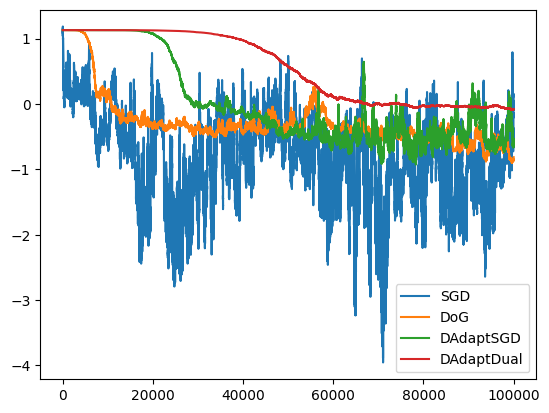

In [78]:
iterations = 100001
init = torch.randn(N, requires_grad=True)

# SGD Method
sgd_model = TorchQuadModel(N, init)
sgd_optimizer = SGD(sgd_model.params(), lr = 0.0001)

# DoG Method
dog_model = TorchQuadModel(N, init)
dog_optimizer = DoG(dog_model.params())

# D-Adaptation (SGD) Method
dadapt_sgd_model = TorchQuadModel(N, init)
dadapt_sgd_optimizer = DAdaptSGD(dadapt_sgd_model.params(), lr = 0.01)

# D-Adaptation (Dual Averaging) Method
dadapt_dual_model = TorchQuadModel(N, init)
dadapt_dual_optimizer = DAdaptDual(dadapt_dual_model.params())


optimizers = [[sgd_optimizer, sgd_model],
            [dog_optimizer, dog_model],
            [dadapt_sgd_optimizer, dadapt_sgd_model],
            [dadapt_dual_optimizer, dadapt_dual_model]]
for i, (optimizer, model) in enumerate(optimizers):
    optimizer_name = optimizer.__class__.__name__
    print(f"{optimizer_name} Method")
    point_dist_list, value_dist_list, log_dist_list = quadratic_model_runner(optimizer,
                                                                                model, P,
                                                                                q,
                                                                                qs.optimal_point(), max_iter=iterations, log_per_iteration=1000,
                                                                                is_noisy=True,
                                                                                noise_std=100)

    plt.plot(log_dist_list, label=optimizer_name)

plt.legend()
plt.show()

In [80]:
print(f"Actual optimal point: \t{qs.optimal_value()}")
print(f"DoG optimal point: \t{dog_model.optimal_value()}")
print(f"SGD optimal point: \t{sgd_model.optimal_value()}")
print(f"D-Adapt (SGD) optimal point: \t{dadapt_sgd_model.optimal_value()}")
print(f"D-Adapt (DA) optimal point: \t{dadapt_dual_model.optimal_value()}")

Actual optimal point: 	-0.9880231213224634
DoG optimal point: 	-0.5818068385124207
SGD optimal point: 	-0.9688670635223389
D-Adapt (SGD) optimal point: 	-0.5922625064849854
D-Adapt (DA) optimal point: 	-0.06840451061725616
